In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM, Dense, Conv1D
from keras.models import Model, Sequential, save_model
from typing import Dict, List, Tuple, Optional, Sequence
from IPython import display

import datetime
import os
import glob
import numpy as np
import pathlib
import pretty_midi 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

SAMPLING_RATE = 16000

In [4]:
data_dir = r"C:\Users\aashutosh kumar\Videos\maestro-v2.0.0"
filenames = []

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.mid') or file.endswith('.midi'):
            filenames.append(os.path.join(root, file))

print('Number of files:', len(filenames))

Number of files: 1282


In [5]:
filenames[:5]

['C:\\Users\\aashutosh kumar\\Videos\\maestro-v2.0.0\\2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.midi',
 'C:\\Users\\aashutosh kumar\\Videos\\maestro-v2.0.0\\2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi',
 'C:\\Users\\aashutosh kumar\\Videos\\maestro-v2.0.0\\2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_08_Track08_wav.midi',
 'C:\\Users\\aashutosh kumar\\Videos\\maestro-v2.0.0\\2004\\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_10_Track10_wav.midi',
 'C:\\Users\\aashutosh kumar\\Videos\\maestro-v2.0.0\\2004\\MIDI-Unprocessed_SMF_05_R1_2004_01_ORIG_MID--AUDIO_05_R1_2004_02_Track02_wav.midi']

Determining Pitch, Step and duration


In [6]:
file = filenames[1]
print("The file is : ",file)

pre = pretty_midi.PrettyMIDI(midi_file = file)
print("Number of instruments is: ", len(pre.instruments))

instrument = pre.instruments[0]
name_of_instrument = pretty_midi.program_to_instrument_name(instrument.program)

print("The name of instrument is: ", name_of_instrument)

The file is :  C:\Users\aashutosh kumar\Videos\maestro-v2.0.0\2004\MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_06_Track06_wav.midi
Number of instruments is:  1
The name of instrument is:  Acoustic Grand Piano


In [7]:
for i,note in enumerate(instrument.notes[:10]):
    note_name = pretty_midi.note_number_to_name(note.pitch)
    duration = note.end - note.start
    print(f"number:{i}| pitch:{note.pitch}| note_name:{note_name}| duration:{duration: .4f}|")

number:0| pitch:31| note_name:G1| duration: 0.0656|
number:1| pitch:43| note_name:G2| duration: 0.0792|
number:2| pitch:44| note_name:G#2| duration: 0.0740|
number:3| pitch:32| note_name:G#1| duration: 0.0729|
number:4| pitch:34| note_name:A#1| duration: 0.0708|
number:5| pitch:46| note_name:A#2| duration: 0.0948|
number:6| pitch:48| note_name:C3| duration: 0.6260|
number:7| pitch:36| note_name:C2| duration: 0.6542|
number:8| pitch:53| note_name:F3| duration: 1.7667|
number:9| pitch:56| note_name:G#3| duration: 1.7688|


**Converting the midi files into Dataframe**

In [8]:
def midi_to_dataframe(midi_file) -> pd.DataFrame:
    pre = pretty_midi.PrettyMIDI(midi_file)
    instrument = pre.instruments[0]
    sorted_notes = sorted(instrument.notes, key= lambda note: note.start)
    prev_start = sorted_notes[0].start

    pitches, starts, ends, steps, duration = [], [], [], [], []

    for note in sorted_notes :
        pitches.append(note.pitch)
        starts.append(note.start)
        ends.append(note.end)
        steps.append(note.start - prev_start)
        duration.append(note.end - note.start)

    data={
        "pitch" : np.array(pitches),
        "starts" : np.array(starts),
        "ends" : np.array(ends),
        "steps" : np.array(steps),
        "duration" : np.array(duration)
    }

    dataframe = pd.DataFrame(data)
    return dataframe    

In [9]:
sample_file = filenames[1]
data = midi_to_dataframe(sample_file)
data.head(4)

,pitch,starts,ends,steps,duration
0,43,1.032292,1.111458,0.000000,0.079167
1,31,1.040625,1.106250,0.008333,0.065625
2,44,1.142708,1.216667,0.110417,0.073958
3,32,1.144792,1.217708,0.112500,0.072917


In [9]:
data.to_csv('midi_data.csv', index=False)
print("Data saved as 'midi_data.csv'")

Data saved as 'midi_data.csv'


**VISUALIZING THE NOTES**

In [10]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_name = get_note_names(data['pitch'])
print(sample_note_name[:10])

['G2' 'G1' 'G#2' 'G#1' 'A#2' 'A#1' 'C3' 'C2' 'F3' 'D4']


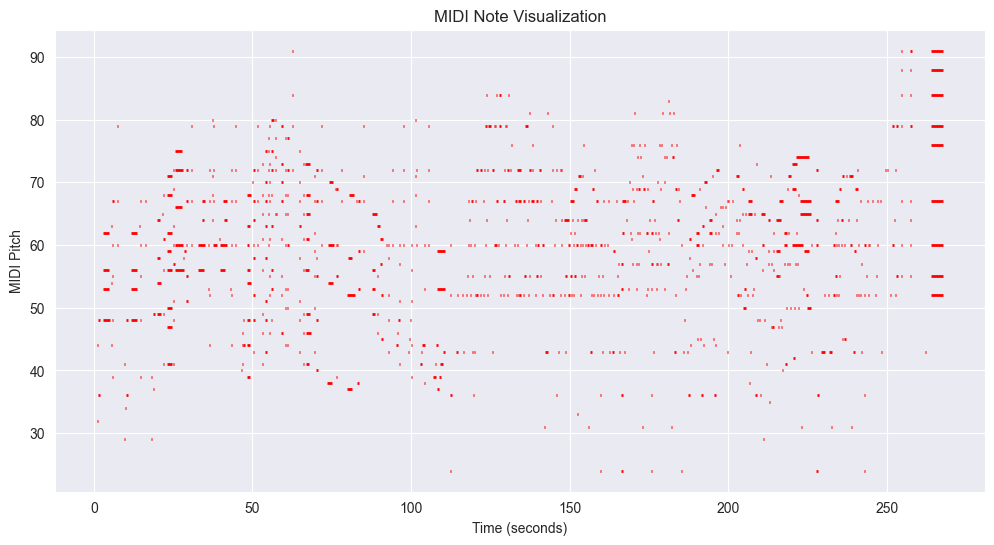

In [11]:
def plot_notes(notes):
    plt.figure(figsize=(12, 6))
    sns.set_style('darkgrid')
    for i in range(len(notes)):
        plt.hlines(y=notes['pitch'][i], xmin=notes['starts'][i], xmax=notes['ends'][i], 
                   colors='red', lw=2)

    plt.xlabel('Time (seconds)')
    plt.ylabel('MIDI Pitch')
    plt.title('MIDI Note Visualization')
    plt.grid(True)
    plt.show()

plot_notes(data)

In [12]:
num_of_files = 5
all_notes = []

for i in filenames[:num_of_files]:
    notes = midi_to_dataframe(i)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)
print("Number of notes parsed are: ", len(all_notes))

Number of notes parsed are:  37241


In [13]:
key_order = ['pitch', 'steps', 'duration']
notes_feature = []

notes_feature = [all_notes[key].values for key in key_order]

notes_ds = tf.data.Dataset.from_tensor_slices(notes_feature)
notes_ds.element_spec

TensorSpec(shape=(37241,), dtype=tf.float32, name=None)

In [14]:
def create_sequences(dataset, seq_length, vocab_size) -> tf.data.Dataset:
    seq_length = seq_length + 1

    windows = dataset.window(seq_length, shift = 1, stride = 1, drop_remainder = True)
    flatten = lambda x: x.batch(seq_length, drop_remainder=True)
    sequences = windows.flat_map(flatten)

    def scale_pitch(x):
        x = x/[vocab_size, 1.0, 1.0]
        return x

    def split_labels(sequences):
        inputs = sequences[:-1]
        labels_dense = sequences[-1]
        labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

        return scale_pitch(inputs), labels
    return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
seq_length = 25
vocab_size = 128
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)

ValueError: in user code:

    File "C:\Users\aashutosh kumar\AppData\Local\Temp\ipykernel_34504\3952525900.py", line 17, in split_labels  *
        return scale_pitch(inputs), labels
    File "C:\Users\aashutosh kumar\AppData\Local\Temp\ipykernel_34504\3952525900.py", line 9, in scale_pitch  *
        x = x/[vocab_size, 1.0, 1.0]

    ValueError: Dimensions must be equal, but are 37241 and 3 for '{{node truediv}} = RealDiv[T=DT_FLOAT](strided_slice, truediv/y)' with input shapes: [25,37241], [3].
